<a href="https://colab.research.google.com/github/jamarju/demo_orla/blob/master/03_entrena_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instrucciones

In [37]:
!pip install -U fastai gdown

In [42]:
!git clone https://github.com/jamarju/face-detection-pytorch
!mv face-detection-pytorch/detectors .
!mv face-detection-pytorch/utils .
!mkdir face-detection-pytorch/detectors/s3fd/weights
!gdown --id 1ktVh55p-Ynu6LonSyZtaUJxU23BS0Pdk -O detectors/s3fd/weights/sfd_face.pth

fatal: destination path 'face-detection-pytorch' already exists and is not an empty directory.
mv: cannot stat 'face-detection-pytorch/detectors': No such file or directory
mv: cannot stat 'face-detection-pytorch/utils': No such file or directory
mkdir: cannot create directory ‘face-detection-pytorch/detectors/s3fd/weights’: No such file or directory
Downloading...
From: https://drive.google.com/uc?id=1ktVh55p-Ynu6LonSyZtaUJxU23BS0Pdk
To: /space/ml/demo_orla/detectors/s3fd/weights/sfd_face.pth
89.8MB [00:02, 39.5MB/s]


In [179]:
!git clone https://github.com/ZHKKKe/MODNet
!gdown https://drive.google.com/uc?id=1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz -O MODNet/pretrained/modnet_photographic_portrait_matting.ckpt

fatal: destination path 'MODNet' already exists and is not an empty directory.
Downloading...
From: https://drive.google.com/uc?id=1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz
To: /space/ml/demo_orla/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt
26.3MB [00:00, 31.8MB/s]


In [279]:
from pathlib import Path
from zipfile import ZipFile
import shutil
import sys

from fastai.basics import *
from fastai.vision.all import *
from fastai.distributed import *
from tqdm.notebook import tqdm

from detectors import S3FD
from utils.bbox import draw_bboxes, crop_thumbnail


In [44]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [45]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    data_d = Path('/content/drive')
else:
    data_d = Path('data')

In [46]:
temp_d = Path('temp')
temp_d.mkdir(exist_ok=True)

In [76]:
%%time
if not (temp_d / 'alumnos').exists():
    with ZipFile(data_d / 'alumnos.zip', 'r') as z:
        z.extractall('temp')

CPU times: user 10.4 ms, sys: 540 µs, total: 11 ms
Wall time: 10.4 ms


In [77]:
alus_d = temp_d / 'alumnos'

In [78]:
alus_d.ls()

(#9) [Path('temp/alumnos/BARTOLOME MARÍ.jpg'),Path('temp/alumnos/LEONARDO DICAPRIO.jpg'),Path('temp/alumnos/NAROA BAÑOS.jpg'),Path('temp/alumnos/ORIOL CORRAL.jpg'),Path('temp/alumnos/CLINT EASTWOOD.jpg'),Path('temp/alumnos/ISABEL CAMARA.jpg'),Path('temp/alumnos/JUAN ESPAÑOL ESPAÑOL.jpg'),Path('temp/alumnos/HERMINIO MONGE.jpg'),Path('temp/alumnos/LUCIANO ATIENZA.jpg')]

In [79]:
imgs = [ np.array(Image.open(p)) for p in alus_d.ls() ]
names = [ p.stem for p in alus_d.ls() ]

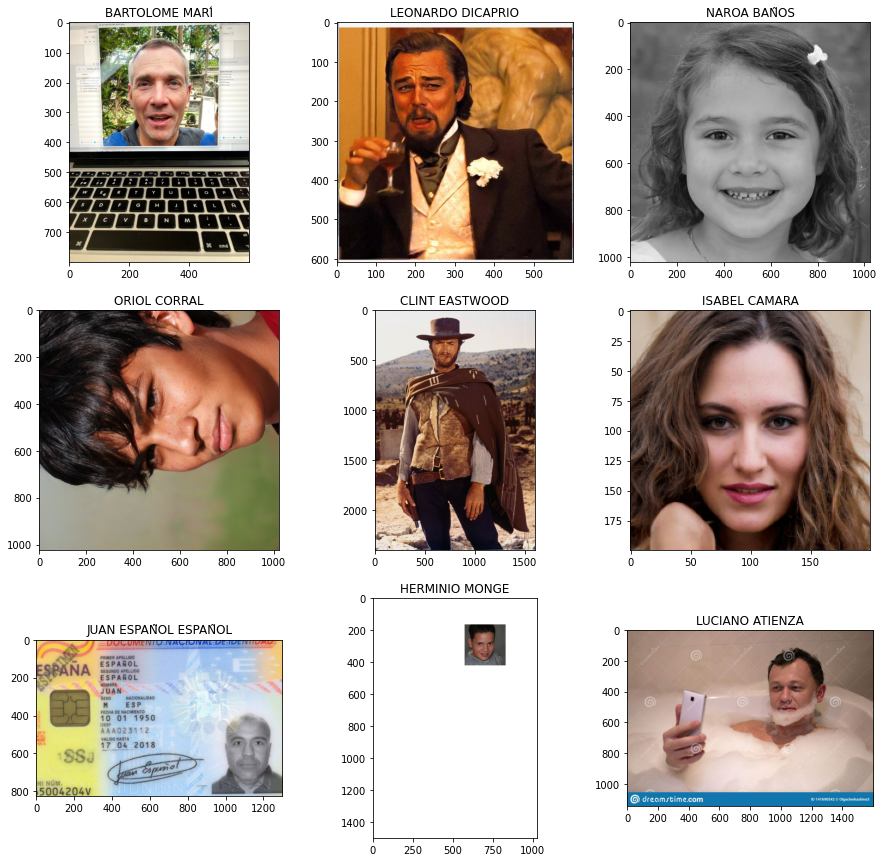

In [80]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(imgs, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

# Paso 1: detección de caras

In [81]:
det = S3FD(device='cuda')

[S3FD] loading with cuda
[S3FD] finished loading (0.1872 sec)


In [366]:
bboxes_l = []
boxed_imgs = []
crops = []

for img in tqdm(imgs):
    bboxes = det.detect_faces(img, conf_th=0.9)
    boxed_img = draw_bboxes(img, bboxes)
    crop, _ = crop_thumbnail(img, bboxes[0], padding=0.7, size=1024)
    bboxes_l.append(bboxes)
    boxed_imgs.append(boxed_img)
    crops.append(crop)


  0%|          | 0/9 [00:00<?, ?it/s]

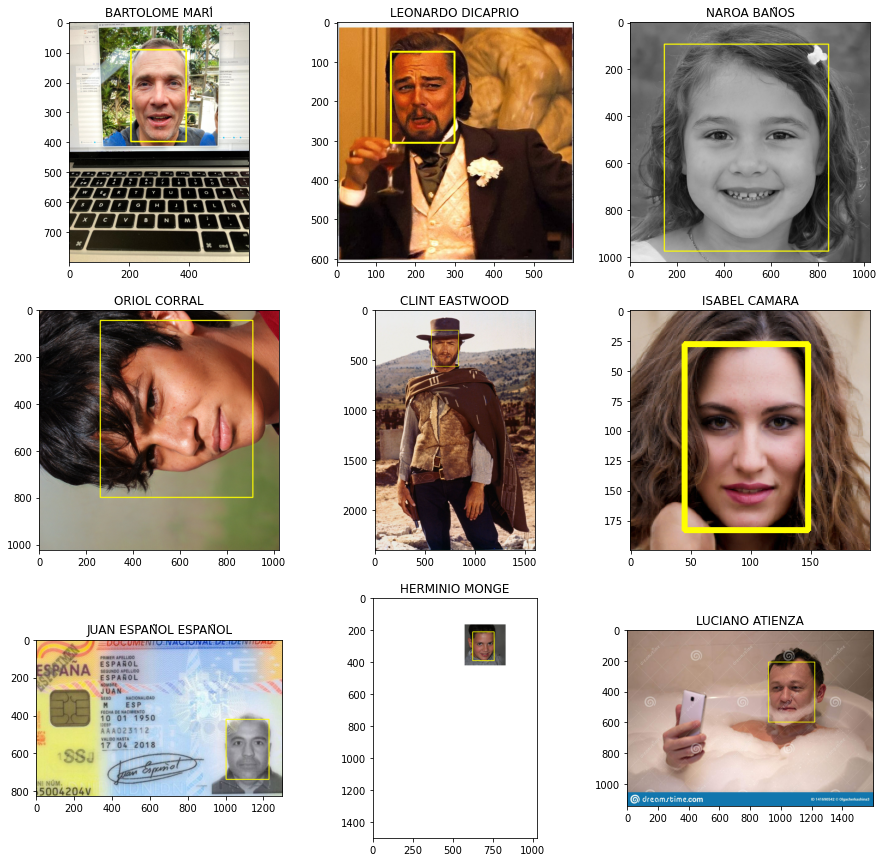

In [367]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(boxed_imgs, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

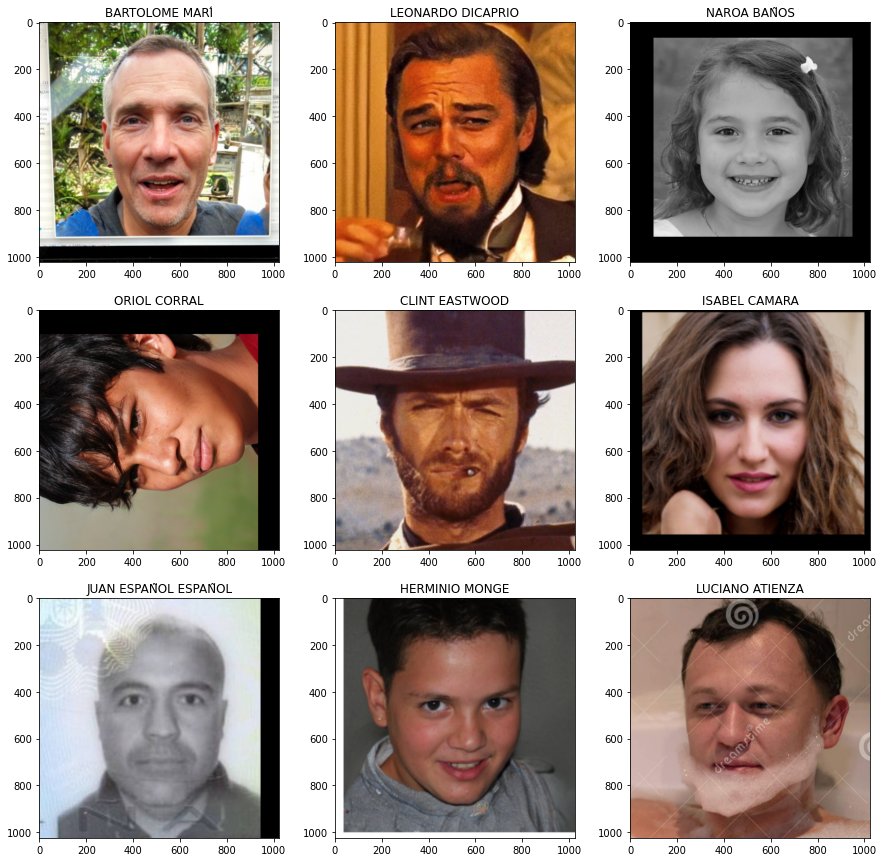

In [368]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(crops, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

# Paso 2: rectificar orientación

In [369]:
tiltnet = load_learner(data_d / 'tiltnet18.pkl', cpu=False)

In [370]:
tiltnet.predict(crops[2])

('0', tensor(0), tensor([0.7817, 0.2075, 0.0061, 0.0047]))

In [371]:
tiltnet.predict(crops[3])

('270', tensor(2), tensor([5.0430e-06, 8.3306e-06, 9.9979e-01, 1.9619e-04]))

In [372]:
str_crops = []

for img in tqdm(crops):
    ori, _, _ = tiltnet.predict(img)
    str_crop = np.array(Image.fromarray(img).rotate(int(ori)))
    str_crops.append(str_crop)

  0%|          | 0/9 [00:00<?, ?it/s]

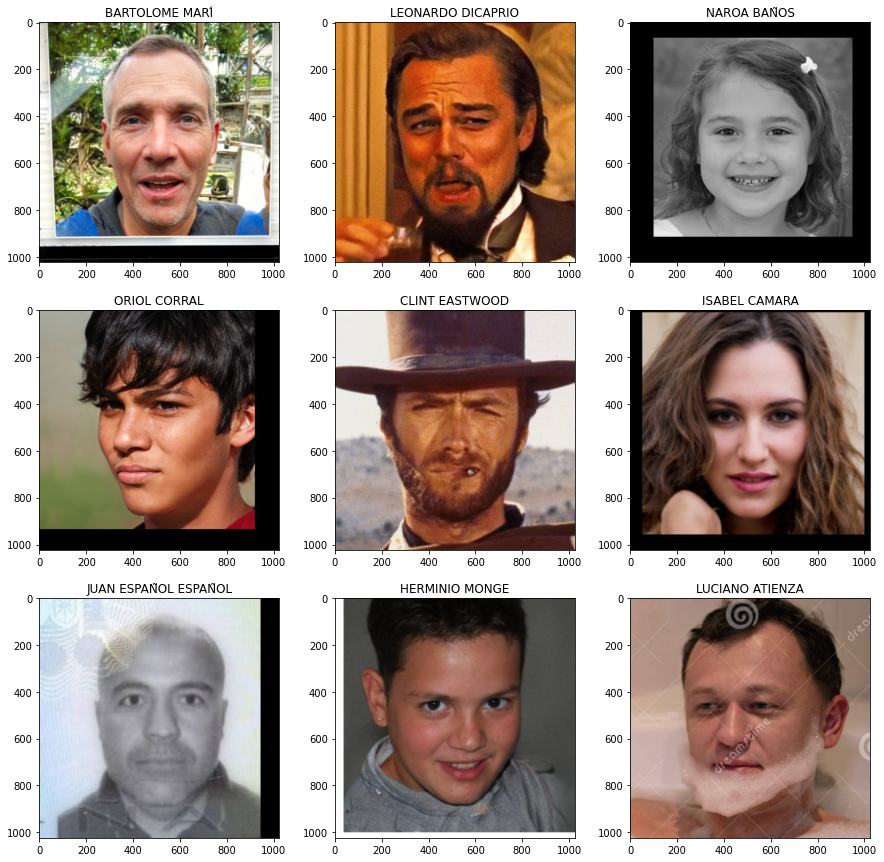

In [373]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(str_crops, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

# Paso 3: bonus track - quitar fondo

Vamos a usar [MODNet](https://github.com/ZHKKKe/MODNet)

In [374]:
shutil.rmtree(temp_d / 'in', ignore_errors=True)
shutil.rmtree(temp_d / 'out', ignore_errors=True)

In [375]:
(temp_d / 'in').mkdir(exist_ok=True)
(temp_d / 'out').mkdir(exist_ok=True)

In [376]:
for img, name in zip(str_crops, names): # imgs, names
    Image.fromarray(img).save(temp_d / 'in' / f'{name}.jpg')

In [377]:
# clone the repository
if not os.path.exists('MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet
%cd MODNet/

# dowload the pre-trained ckpt for image matting
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz \
          -O pretrained/modnet_photographic_portrait_matting.ckpt


/space/ml/demo_orla/MODNet


In [378]:
!python -m demo.image_matting.colab.inference \
        --input-path ../temp/in \
        --output-path ../temp/out \
        --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt

Process image: BARTOLOME MARÍ.jpg
/home/javi/anaconda3/envs/tiltnet/lib/python3.7/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
Process image: LEONARDO DICAPRIO.jpg
Process image: NAROA BAÑOS.jpg
Process image: ORIOL CORRAL.jpg
Process image: CLINT EASTWOOD.jpg
Process image: ISABEL CAMARA.jpg
Process image: JUAN ESPAÑOL ESPAÑOL.jpg
Process image: HERMINIO MONGE.jpg
Process image: LUCIANO ATIENZA.jpg


In [379]:
%cd ..

/space/ml/demo_orla


In [380]:
(temp_d / 'out').ls()

(#9) [Path('temp/out/BARTOLOME MARÍ.png'),Path('temp/out/LEONARDO DICAPRIO.png'),Path('temp/out/NAROA BAÑOS.png'),Path('temp/out/ORIOL CORRAL.png'),Path('temp/out/CLINT EASTWOOD.png'),Path('temp/out/ISABEL CAMARA.png'),Path('temp/out/JUAN ESPAÑOL ESPAÑOL.png'),Path('temp/out/HERMINIO MONGE.png'),Path('temp/out/LUCIANO ATIENZA.png')]

In [381]:
masks = [ np.array(Image.open(p)) for p in (temp_d / 'out').ls() ]

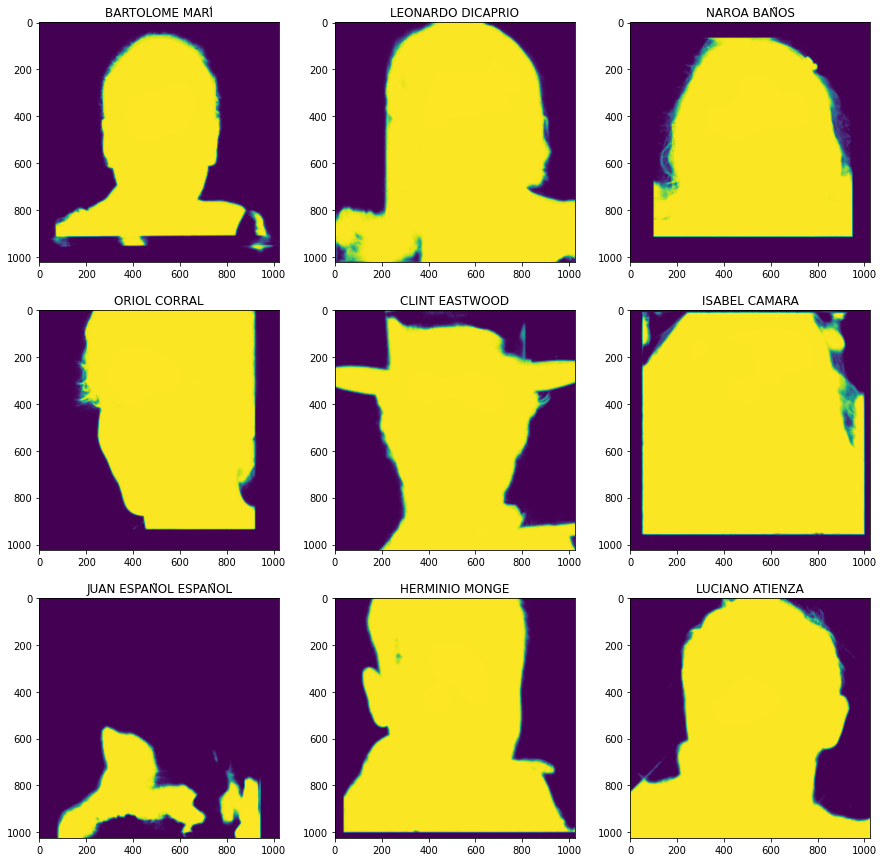

In [382]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(masks, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

In [383]:
finals = []

for img, mask in zip(str_crops, masks):
    final = Image.fromarray(img)
    final.putalpha(Image.fromarray(mask))
    finals.append(final)

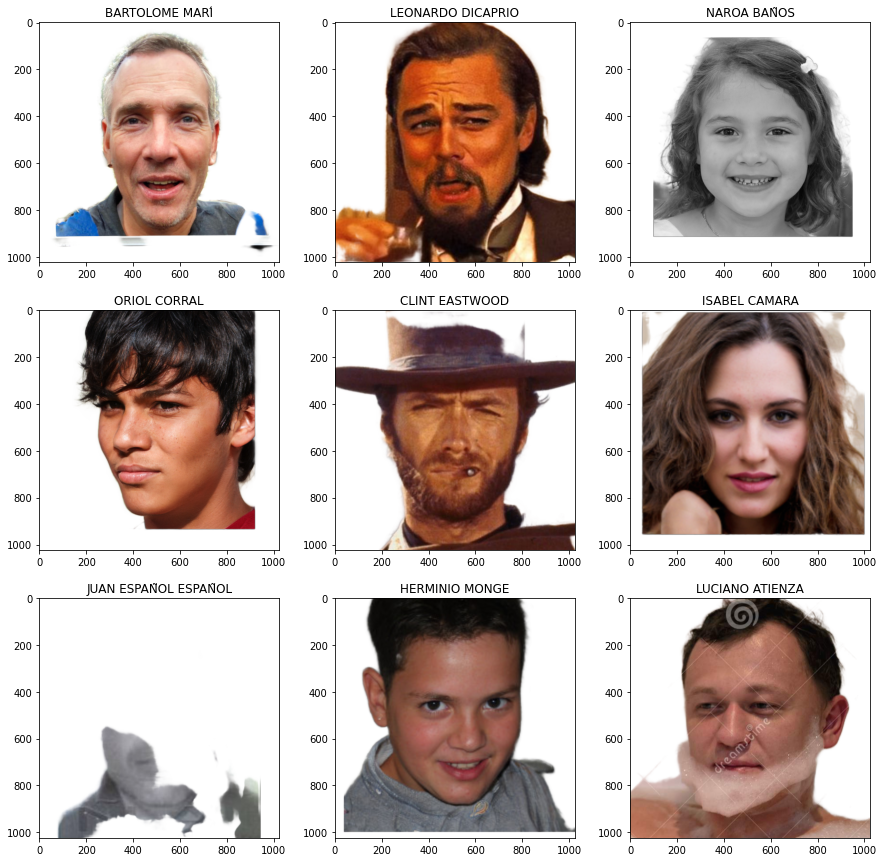

In [384]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(finals, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()